## Map existing PV


In [2]:
# Setup
import pandas as pd
import numpy as np
import datetime as dt

import glob
import os
from pathlib import Path
import itertools

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import colour

from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
# https://matplotlib.org/3.1.0/tutorials/colors/colormap-manipulation.html

from shapely.geometry import Polygon, Point
import geopandas as gpd
import pyproj # Do I need this when I can use geopandas.crs ??
import folium
from folium import plugins

from tqdm import tqdm # Progress bar stuff cos progress bars are good
tqdm.pandas() # now can use progress_apply instead of apply

import pickle # Pickle stuff, cos pickling is good

# Styles
pd.set_option('display.float_format', lambda x: '%.2f' % x) # pandas
np.set_printoptions(precision=5, suppress=True) # numpy

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

In [3]:
pv = pd.read_csv('data/fit_repd_pv.csv')

/Users/laurence/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (11,12,16) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
# Most of REPD has x,y coordinates included
# Most of FiTDB has postcode included

# Print out some key stats

total_cap = pv.cap.sum()
cap_with_xy = pv[pv['x'].notna()]['cap'].sum()
print(f"Total capacity of combined REPD + FiT databases is: {round(total_cap/1000000,2)}GW")
print(f"Total count of REPD + FIT database installations is : {len(pv)}")
print('-'*10)
print(f"PV capacity with x,y coordinates specified is {round(cap_with_xy/1000000,2)} GW")
print(f"That's {round(100*cap_with_xy/total_cap, 2)}% of all PV capacity in the UK")
print('-'*10)
cap_with_postcode = pv[pv.postcode.notna()].cap.sum().round(0)
print(f"PV with postcode area specified is {round(cap_with_postcode/1000000,2)} GW")
print(f"That's {round(100*cap_with_postcode/total_cap)}% of all PV capacity")
print('-'*10)
cap_no_loc = pv[pv['x'].isna() & pv['postcode'].isna()].cap.sum()
print(f"Almost no capacity with no location info, {round(100*cap_no_loc/total_cap,2)}%, {cap_no_loc/1000} MW")

Total capacity of combined REPD + FiT databases is: 13.13GW
Total count of REPD + FIT database installations is : 840777
----------
PV capacity with x,y coordinates specified is 8.14 GW
That's 61.99% of all PV capacity in the UK
----------
PV with postcode area specified is 10.7 GW
That's 81.0% of all PV capacity
----------
Almost no capacity with no location info, 0.13%, 17.0 MW


The BEIS deployment statistics from Feb 2019 have 13,070.4 MW installed.  
As of 29th June there is 13,247MW.  
>Overall this implies some overlap between the REPD and the FiT dbs.  
>This should be removed or it will invalidate my spatial analysis.
Overlap now removed. 

In [5]:
13.247-13.13

0.1169999999999991

In [6]:
1 - (13.13 - .17) / 13.247 

0.021665282705518152

In [7]:
(1004798 - 840777)/1004798

0.16323778510705633

So most of capacity is installed. Possibly some of those other installations are no longer operating.

In [8]:
# Commissioning date missing, present
pv[pv['comm_date'].isna()].cap.sum(), pv[pv['comm_date'].notna()].cap.sum()

(8159889.0, 4965576.269999999)

In [9]:
pv[(pv['source']=='REPD') & (pv['comm_date'].isna())].cap.sum()

8159889.0

ie all REPD sources do not have commissioning dates, all FiT do.

### Plot all existing arrays

Using the pv dataframe, plot by postcode or x,y coordinate.  
Consider how to aggregate by postcode (2 Letter?)  
Then produce a heatmap / some sort of binning / grid ? 

In [10]:
pv.groupby('postcode').cap.sum().head()

postcode
AB10    230.50
AB11    252.79
AB12   1068.39
AB13     70.64
AB14    154.26
Name: cap, dtype: float64

In [30]:
import datetime

In [39]:
pv['comm_date'] = pd.to_datetime(pv['comm_date'], utc=True)

In [43]:
la_pv = pv[pv.comm_date<pd.to_datetime('2015-01-01').tz_localize('UTC')]\
        .assign(cap_mean = lambda x: x.cap)\
        .assign(cap_median = lambda x: x.cap)\
        .groupby('la')\
        .agg({'comm_date': 'count', 'cap': 'sum', 'cap_mean': 'mean', 'cap_median': 'median'})

In [44]:
towns = ['Bristol City of', 'Cambridge', 'Canterbury', 'Knowsley', 'Liverpool', 'Manchester', 'Peterborough']

### City stats

In [45]:
la_pv[la_pv.index.isin(towns)]

,comm_date,cap,cap_mean,cap_median
la,,,,
Bristol City of,3131,11141.77,3.56,2.76
Cambridge,999,3470.34,3.47,2.76
Canterbury,1499,5824.23,3.89,3.38
Knowsley,2423,7567.47,3.12,2.88
Liverpool,1752,6568.54,3.75,3.00
Manchester,3132,10329.14,3.30,2.70
Peterborough,5203,17221.23,3.31,2.55


## Postcode polygons

Postcodes full datafile has 1.6m rows and is very unwieldy.  
This is now a 1.4GB (!) shapefile at `Dropbox/Data/shapefiles/postcode_polygons/all_UK_postcodes.shp`  
I dissolve geometries down to postcode area to get 119 postcode area geometries which are a little more manageable.  
Both files are saved for future use.

In [7]:
# Create monster shapefile

# sf_dir = '../../Data/shapefiles/postcode_polygons/shapefiles/'
# # !ls $sf_dir

# # Combine all shapefiles
# pcodes = pd.concat([
#                 gpd.read_file(shp)
#                 for shp in glob.glob(sf_dir + "*.shp")
# ]).pipe(gpd.GeoDataFrame)
# pcodes.to_file('../../Data/shapefiles/postcode_polygons/all_UK_postcodes.shp')

In [8]:
# Read in 1.4GB shapefile for all UK Postcodes.... or not... 
# pcodes = gpd.read_file('../../Data/shapefiles/postcode_polygons/all_UK_postcodes.shp')

In [9]:
# Remove 'virtual' postcodes which I'm not sure how to deal with
# pcodes_no_virtual = pcodes.copy()[pcodes['POSTCODE'].str.contains(' ')]

Use more usable Postcode Districts

In [10]:
# # Create more usable Postcode Districts
# # Create district column
# # pcodes_no_virtual['PC_DISTRICT'] = pcodes_no_virtual['POSTCODE'].apply(lambda x: x.split(' ')[0])

# pc_districts = pcodes_no_virtual.dissolve(by='PC_DISTRICT').drop(['UPP', 'POSTCODE'], axis=1)
# pc_districts = pc_districts.reset_index()
# # Export
# pc_districts.to_file('../../Data/shapefiles/postcode_polygons/all_UK_postcode_districts.shp')

Use even more usable Postcode Areas

In [11]:
# # dissolve down to postcode areas
# pc_areas = pcodes.dissolve(by='PC_AREA', aggfunc = 'sum'))

# # Remove useless columns
# pc_areas = pc_areas.drop(['POSTCODE', 'UPP'], axis=1)
# pc_areas = pc_areas.reset_index()
# # Export
# pc_areas.to_file('../../Data/shapefiles/postcode_polygons/all_UK_postcode_areas.shp')

In [12]:
# Get postcode areas and districts
pc_areas = gpd.read_file('../../Data/shapefiles/postcode_polygons/all_UK_postcode_areas.shp')
pc_districts = gpd.read_file('../../Data/shapefiles/postcode_polygons/all_UK_postcode_districts.shp')

In [13]:
# Plot Postcode Areas and Postcode Districts

# fig, axes = plt.subplots(1, 2, figsize=(8, 8))
# pc_areas.plot(linewidth=0.2, column='PC_AREA',  cmap='viridis', ax=axes[0])
# pc_districts.plot(linewidth=0.1, ax=axes[1])
# for ax in axes: 
#     ax.axis('off')

In [14]:
# Turn polygons into points for efficient plotting and for a heatmap
pc_centroids = pc_districts.copy()
pc_centroids['geometry'] = pc_districts['geometry'].centroid

(37369.300849004765,
 680916.2978588962,
 -42625.872701156826,
 1072637.6685967261)

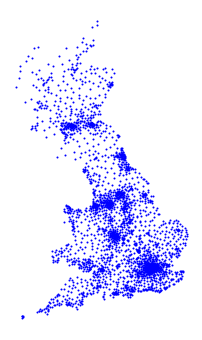

In [15]:
fig, ax = plt.subplots(1, figsize=(6, 6))
pc_centroids.plot(color='blue', markersize=1, ax=ax)
ax.axis('off')

Calculate nearest neighbour points to get some average uncertainty for a Postcode District

In [16]:
# https://automating-gis-processes.github.io/2017/lessons/L3/nearest-neighbour.html
from shapely.ops import nearest_points

def nearest(row, geom_union, df1, df2, geom1_col='geometry', geom2_col='geometry', src_column=None):
    """Find the nearest point and return the corresponding value from specified column."""
    # Find the geometry that is closest
    nearest = df2[geom2_col] == nearest_points(row[geom1_col], geom_union)[1]
    # Get the corresponding value from df2 (matching is based on the geometry)
    value = df2[nearest][src_column].get_values()[0]
    return value

unary_union = pc_centroids.unary_union

In [17]:
# pc_centroids['nearest_id'] = pc_centroids.apply(nearest, geom_union=unary_union, df1=pc_centroids, df2=pc_centroids, geom1_col='geometry', src_column='DISTRICT', axis=1)

In [18]:
pc_centroids['nearest_id'] = pc_centroids.geometry.apply(lambda x: nearest_points(x, unary_union - x))

In [19]:
# Take the second point (ie not the original centroid, as nearest_points returns tuple)
pc_centroids['nearest_id'] = [x[1] for x in pc_centroids.nearest_id]

In [20]:
type(pc_centroids.geometry), type(pc_centroids.nearest_id)

(geopandas.geoseries.GeoSeries, pandas.core.series.Series)

In [21]:
# Distance is half distance to closest neighbour... not that scientific
# Also - 'distance' in BNG coordinates
pc_centroids['nearest_dist'] = pc_centroids.geometry.distance(gpd.GeoSeries(pc_centroids.nearest_id))/2

In [22]:
pc_centroids.nearest_dist.mean()

2743.029960677692

Slightly tricky to use this to calculate rough size / area of postcode districts or mean uncertainty...  
Should calc area of each one and then assume rough shape...?  
Useful stuff here: https://beacon-dodsworth.co.uk/blog/all-you-need-to-know-about-postcodes-but-were-afraid-to-ask/
33sq miles is average area of postcode district  
Which very roughly means 9km square side, so +- 5km accuracy?

In [23]:
len(pc_centroids)

2752

## Combine PV database with postcodes

In [24]:
# For PV database:
# Turn all letters to uppercase
pv.postcode = pv.postcode.str.upper()

In [25]:
print(f"There are {len(pv[pv.postcode.isna()])} PV arrays with no postcode data out of {len(pv)}")

There are 312 PV arrays with no postcode data out of 840777


In [26]:
# Create postcode district for all arrays with postcode data
has_pc = pv[pv.postcode.notna()]
print(f"{len(has_pc[has_pc.postcode.str.contains(' ')])} arrays with full Postcode, {len(has_pc)} with just postcode district or postcode area")

752 arrays with full Postcode, 840465 with just postcode district or postcode area


In [27]:
def make_district(x):
    # if na return na
    if x == 'NaN':
        return np.nan
    # if UNKNOWN return na
    elif x == 'UNKNOWN':
        return np.nan
    else:
        try:
            return x.split(' ')[0]
        except:
            return x

In [28]:
pv['pc_district'] = pv.postcode.apply(lambda x: make_district(x))

In [29]:
# need to create columns just of PV District

# Replace NaNs with 'Unknown' ( could have done this in function above too)
pv.loc[pv['pc_district'].isna(),'pc_district'] = 'Unknown'

pc_district_cap = pv.groupby('pc_district').sum()[['cap']].sort_values('cap', ascending=False)
pc_district_cap.head(10)

,cap
pc_district,
Unknown,3919434.34
SG8,177631.84
SN6,127732.49
BH23,88631.32
NR21,77999.81
SN15,77275.40
EX22,69894.82
CB6,67017.56
OX13,65486.16


In [30]:
print(f"Sum of PV capacity: {round(pc_district_cap.cap.sum()/1000000, 2)}GW")
print(f"Sum of PV capacity with unknown postcode info {round(pc_district_cap.loc['Unknown'].cap/1000000, 2)}GW")
print(f"Sum of PV capacity with known postcode info {round((pc_district_cap.cap.sum() - pc_district_cap.loc['Unknown'].cap)/1000000, 2)}GW")

Sum of PV capacity: 13.13GW
Sum of PV capacity with unknown postcode info 3.92GW
Sum of PV capacity with known postcode info 9.21GW


In [31]:
print(f"Capacity with no district and coordinates: {round(pv[(pv['pc_district'] == 'Unknown') & pv['x'].notna()].cap.sum()/1000000, 2)}GW")
      
no_location = pv[(pv['pc_district'] == 'Unknown') & pv['x'].isna()]
print(f"Capacity with no district and no coordinates: {round(no_location.cap.sum()/1000000, 2)}GW")

Capacity with no district and coordinates: 2.41GW
Capacity with no district and no coordinates: 1.51GW


### Investigate amount of capacity with No Location given

In [32]:
no_location.cap.mean()

106.86580686330015

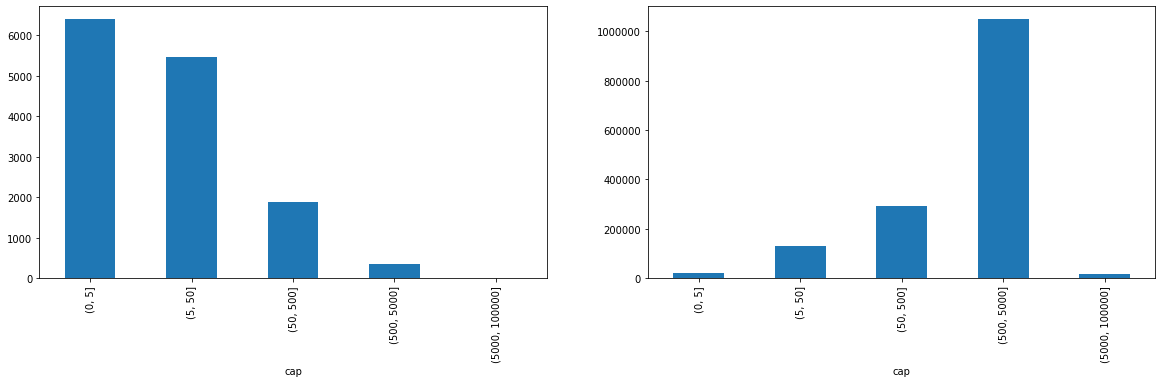

In [33]:
# https://stackoverflow.com/questions/45273731/binning-column-with-python-pandas
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,5))
bins = [0, 5, 50, 500, 5000, 100000]
no_location.groupby(pd.cut(no_location['cap'], bins)).size().plot(kind='bar', ax=ax1)
no_location.groupby(pd.cut(no_location['cap'], bins))['cap'].sum().plot(kind='bar', ax=ax2)

### Consider geocoding the REPD rows without postcodes

In [34]:
# Can use address or x&y coordinates
list(pv[pv.postcode.isna()].reset_index().address)[0]

'Fen Farm, Fen Lane, Conisholme, South Lincolnshire'

In [35]:
# use google geocoder to return postcode from x and y
pv[pv.postcode.isna()].reset_index().head(1)

,index,postcode,cap,comm_date,export,type,country,la,school,lsoa,id,source,name,address,region,x,y,start_date,pc_district
0,839694,NaN,1000.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1018.00,REPD,Fen Farm Solar Park,"Fen Farm, Fen Lane, Conisholme, South Lincolns...",East Midlands,537585.00,393825.00,2011-07-11T00:00:00Z,Unknown


## Plot chloropleth of PV capacity by Postcode Districts

In [36]:
pv_districts = pc_districts.join(pc_district_cap, on='DISTRICT')

In [37]:
pv_districts.head(1)

,PC_AREA,DISTRICT,geometry,cap
0,AB,AB10,"POLYGON ((391671.1525879906 804447.8084653739,...",230.50


/Users/laurence/anaconda3/lib/python3.7/site-packages/matplotlib/colors.py:479: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


(-27010.801285452028,
 688512.7961429323,
 -47255.77242062128,
 1109710.4764356145)

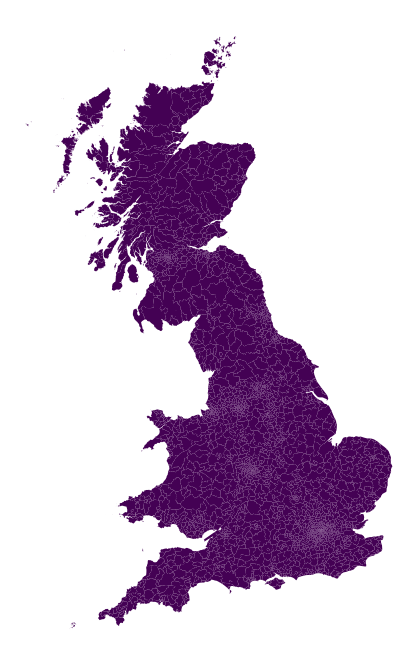

In [38]:
fig, ax = plt.subplots(1, figsize=(12, 12))
pv_districts.plot(linewidth=0.01, column='cap',  cmap='viridis', ax=ax) # Other cmaps YlGn
ax.axis('off')

Now, can use pc_district centroids as points, along with the individual located x-y points from the RED for example.

In [39]:
pv_d_c = pv_districts.copy()
pv_d_c['geometry'] = pv_d_c['geometry'].centroid

(37369.3013775031, 680916.3013048044, -42625.871615043114, 1072637.6694247527)

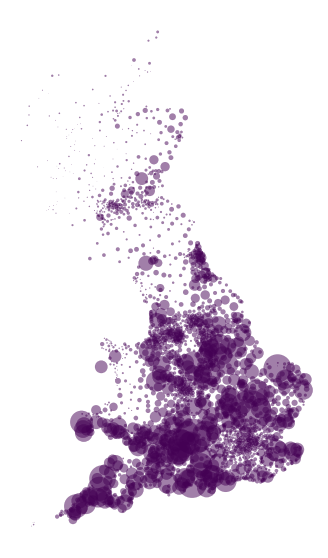

In [40]:
# Quite cool looking
fig, ax = plt.subplots(1, figsize=(10, 10))
pv_d_c.plot(linewidth=0.2, column='cap', markersize=pv_d_c['cap']/100, alpha=0.5, ax=ax) # Other cmaps YlGn
ax.axis('off')

In [41]:
xy = pv[(pv.x.notna()) & (pv.y.notna()) & (pv.pc_district == 'Unknown')]

In [42]:
print(f"{len(xy)} with coordinates and missing district")
print(f"{xy.cap.sum()} kW with coordinates and missing district")
print(f"{len(pv[(pv.x.notna()) & (pv.y.notna())])} with coordinates")
print(f"{round(pv[(pv.x.notna()) & (pv.y.notna())].cap.sum()/1000000,2)}GW with coordinates")
print(f"{round(100*pv[(pv.x.notna()) & (pv.y.notna())].cap.sum()/pv.cap.sum(),2)}% with coordinates")
print(f"{len(pv[pv.pc_district == 'Unknown'])} with missing district")
print(f"{round(pv[pv.pc_district != 'Unknown'].cap.sum()/1000000,2)}GW with district")
print(f"{round(pv[pv.pc_district == 'Unknown'].cap.sum()/1000000,2)} GW with missing district")

310 with coordinates and missing district
2412199.0 kW with coordinates and missing district
1080 with coordinates
8.14GW with coordinates
61.99% with coordinates
14414 with missing district
9.21GW with district
3.92 GW with missing district


In [43]:
print(f"There is {round(pv[(pv.x.isna()) & (pv.y.isna()) & (pv.pc_district == 'Unknown')].cap.sum()/1000000,2)}GW without coordinates or postcode district")

There is 1.51GW without coordinates or postcode district


In [44]:
xy['xy'] = list(zip(xy['x'], xy['y']))

/Users/laurence/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [45]:
xy['geometry'] = xy['xy'].apply(lambda x: Point(x))

/Users/laurence/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [46]:
xy = gpd.GeoDataFrame(xy, crs={'init':'epsg:27700'})

(37369.302180327664, 680916.2976384535, -42625.87118262196, 1072637.6676132097)

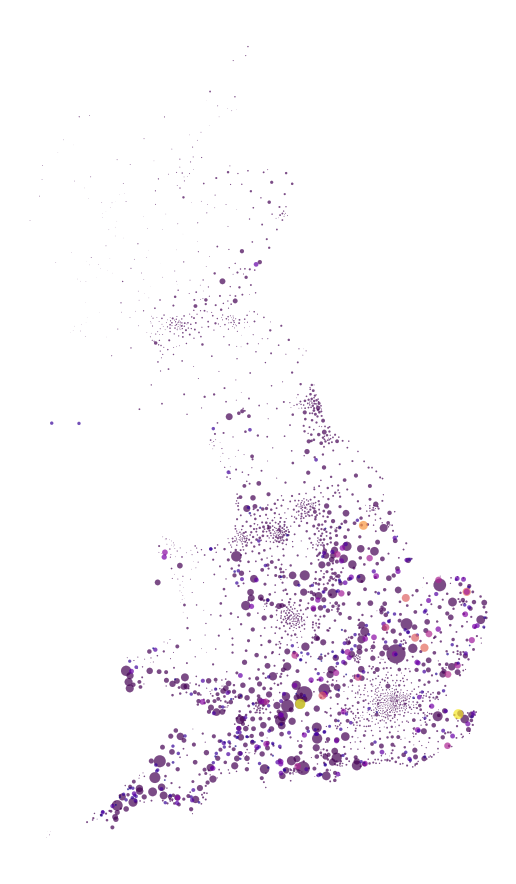

In [47]:
# Quite cool looking
fig, ax = plt.subplots(1, figsize=(16, 16))
pv_d_c.plot(linewidth=0.2, column='cap', markersize=pv_d_c['cap']/500, cmap='viridis', alpha=0.7, ax=ax) # Other cmaps YlGn
xy.plot(linewidth=0.2, column='cap', markersize=xy['cap']/500, cmap='plasma', alpha=0.7, ax=ax)
ax.axis('off')

In [48]:
total = pd.concat([pv_d_c[['geometry', 'cap']], xy[['geometry', 'cap']]])
total = gpd.GeoDataFrame(total, crs={'init': 'epsg:27700'})                

In [49]:
# for_folium = total.to_crs(epsg='4326').to_json()

In [50]:
# Background img 
# https://geopandas.readthedocs.io/en/latest/gallery/plotting_basemap_background.html

# Do this with FastMarkerCluster from Folium Plugs

# m = folium.Map([52.5, -2], zoom_start=7)

# folium.GeoJson(for_folium).add_to(m)

# m

In [51]:
points = total.to_crs(epsg='4326')
print(f"{points[points.cap.isna()].count().geometry} points with no capacity")

59 points with no capacity


In [52]:
points = points.dropna()
print('Dropped any PV arrays without capacity data')

Dropped any PV arrays without capacity data


In [53]:
for_folium = list(zip(points.geometry.y, points.geometry.x, points.cap))

In [54]:
# https://python-visualization.github.io/folium/plugins.html#folium-plugins
# Heatmap: data (list of points of the form [lat, lng] or [lat, lng, weight])
# The points you want to plot. You can also provide a numpy.array of shape (n,2) or (n,3).

# m = folium.Map([52.5, -2], zoom_start=7)

# # plot heatmap
# # m.add_child(plugins.HeatMap(points, radius=15))
# plugins.HeatMap(for_folium, min_opacity=0.01, max_zoom=18, max_val=0.8, radius=8).add_to(m)
# m

In [55]:
# BONUS
# Make HeatMapWithTime

## Plot all PV by Postcode Area and by District

In [56]:
total_pv = round(pv.cap.sum()/1000000,2)
located_pv = round(total.cap.sum()/1000000,2)
print(f"Total capacity of located PV is {located_pv}GW")
print(f"Total PV is {total_pv}GW")
print(f"Missing: {round(total_pv - located_pv,2)}GW")
print(f"{100*round(located_pv/total_pv,2)}% of UK PV")
# TODO why is this higher than the 1.51GW above?

Total capacity of located PV is 11.42GW
Total PV is 13.13GW
Missing: 1.71GW
87.0% of UK PV


In [57]:
# Postcode area
pc_areas = gpd.GeoDataFrame(pc_areas, crs={'init': 'epsg:27700'})
joined = gpd.sjoin(pc_areas, total)
caps = joined.groupby('PC_AREA').sum()
chloro_area = pc_areas.join(caps, on='PC_AREA')

In [58]:
# Postcode district
pc_districts = gpd.GeoDataFrame(pc_districts, crs={'init': 'epsg:27700'})
chloro_district = gpd.sjoin(pc_districts, total)

In [59]:
chloro_area['cap_mw'] = chloro_area['cap']/1000

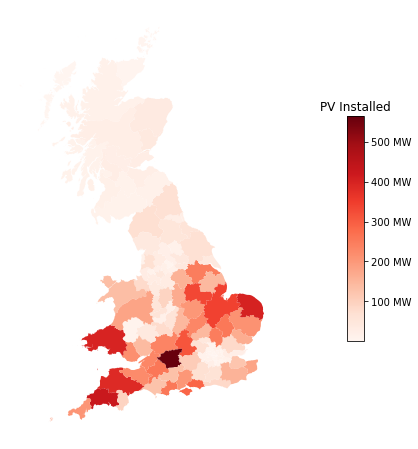

In [60]:
# fig, ax = plt.subplots(1, 2, figsize=(12, 8))
fig, ax = plt.subplots(figsize=(12,8))
chloro_area.plot(linewidth=0.01, column='cap_mw', cmap='Reds', ax=ax)
# chloro_district.plot(linewidth=0.01, column='cap',  cmap='Reds', ax=ax[1])

# ax.set_title("PV by Postcode Area", fontdict={'fontsize': '16', 'fontweight' : '3'})
# ax[1].set_title("PV by Postcode District", fontdict={'fontsize': '16', 'fontweight' : '3'})

# fig.suptitle('87% of UK PV with Location Data', fontsize=25)
ax.axis('off')
# fig.colorbar(fraction=0.15)
# ax[1].axis('off')
# plt.savefig('img/initial_pv_locations_area_district.png', dpi=300)
cbax = fig.add_axes([0.75, 0.3, 0.02, 0.39])   
cbax.set_title('PV Installed')

sm = plt.cm.ScalarMappable(cmap='Reds', \
                norm=plt.Normalize(vmin=min(chloro_area.cap_mw), vmax=max(chloro_area.cap_mw)))
sm._A = []
fig.colorbar(sm, cax=cbax, format="%.0f MW")
# plt.savefig('img/chart_pv_locations_area.png', bounding_box='tight', dpi=300)

Postcode Area seems more appropriate for the whole UK. See DeepSolar paper - they then do more detailed views for specific regions ie use Postcode Districts for a given region / county / part of the country.  
Some sort of metric against population / building development could be interesting...  
Use MSOA as they are done on equal population?  

Compare with MSOA?  
But MSOAs are smaller than postcode areas  

How about counties?

In [61]:
# msoa = gpd.read_file('../../Data/shapefiles/Middle_Layer_Super_Output_Areas_December_2011_Generalised_Clipped_Boundaries_in_England_and_Wales/Middle_Layer_Super_Output_Areas_December_2011_Generalised_Clipped_Boundaries_in_England_and_Wales.shp')
# msoa.plot(linewidth=0.01, figsize=(6,6))


In [62]:
borough = gpd.read_file('../../Data/shapefiles/Download_UK+boundaries_1183810/boundaryline_2856970/district_borough_unitary.shp')
# borough.plot(linewidth=0.01, figsize=(12, 12))

Use downloaded counties shapefiles.  
Convert to BNG coordinates.  

## Deployment Over Time

Merge together REPD commission date and FIT Start date

In [63]:
pv['comm_date'] = pd.to_datetime(pv.comm_date)

In [64]:
pv['start_date'] = pd.to_datetime(pv.start_date)

In [65]:
# Fill date NAs with start_date
pv['date'] = pv.apply(
    lambda row: row['comm_date'] if pd.isna(row['start_date']) else row['start_date'],
    axis=1
)

In [66]:
pv.head(1)

,postcode,cap,comm_date,export,type,country,la,school,lsoa,id,source,name,address,region,x,y,start_date,pc_district,date
0,YO32,6.82,2019-02-27 00:00:00+00:00,Export (Deemed),Domestic,England,York,Not Community Or School,E01013437,nan,fitsDB,NaN,NaN,Yorkshire and The Humber,nan,nan,NaT,YO32,2019-02-27 00:00:00+00:00


In [67]:
print(f"{round(pv[pv.date.notna()].cap.sum()/1000000,2)}GW has commission date")

13.13GW has commission date


In [68]:
len(pv[pv.date.notna()])

840777

800,000 points to plot...

In [69]:
max(pv[pv.date.notna()].cap)

69800.0

In [70]:
# sns.palplot(sns.color_palette("Paired"))

In [71]:
# Colour via kernel density estimator?!
# https://stackoverflow.com/a/37299207
from scipy.stats import gaussian_kde as kde
from sklearn.neighbors import KernelDensity
from matplotlib.colors import Normalize
from matplotlib import cm

In [72]:
# Make small for testing
# df = pv[:10000]
df = pv

In [73]:
# # N = 840833
# N = 100000
# mean = [0,0]
# cov = [[2,2],[0,2]]

# samples = np.random.multivariate_normal(mean,cov,N) # .T for scipy kde
# densObj = kde( samples )

In [74]:
# densObj.evaluate(samples)

In [75]:
# # The evaluate step is very slow with large number of points
# # See here: https://jakevdp.github.io/blog/2013/12/01/kernel-density-estimation/
# # Try sklearn Kernel Density instead

# kde_skl = KernelDensity(bandwidth=0.2, rtol=1E-4)
# densObj = kde_skl.fit(samples)

In [76]:
# densObj.score_samples(samples)

In [77]:
# densObj.score_samples(list(zip(samples[0], samples[1])))

In [78]:
# samples = np.array(df['date'], df['cap'])
# densObj = kde(samples)

def makeColours(vals):
    colours = np.zeros((len(vals),3))
    norm = Normalize( vmin=vals.min(), vmax=vals.max())

    # Can put any colormap you like here.
    colours = [cm.ScalarMappable(norm=norm, cmap='Blues').to_rgba(val) for val in vals]
    return colours

# colours = makeColours(densObj.evaluate(samples))

In [79]:
import math
df['ln_cap'] = df['cap'].apply(lambda x: 5 * math.log(x,2))

In [80]:
from sklearn.preprocessing import normalize
from sklearn.preprocessing import minmax_scale

In [81]:
df['normalised'] = 1000*(normalize(np.array(df['cap']).reshape(-1,1), norm='max', axis=0))
# or 
# df['normalised'] = minmax_scale(np.array(df['cap']).reshape(-1,1), feature_range=(1,1000), axis=0)

# Deployment Chart

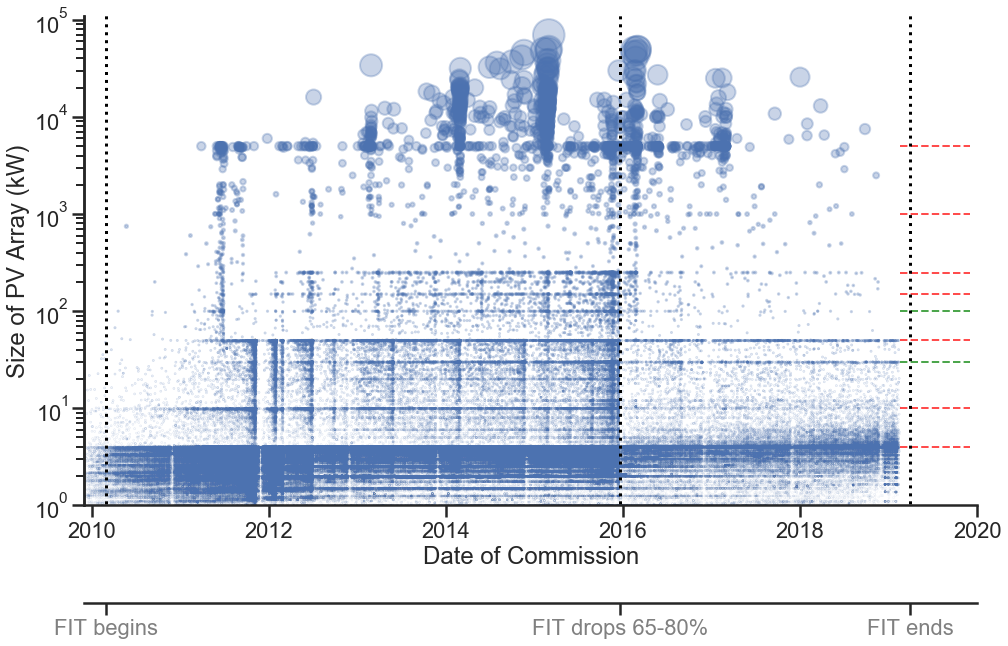

In [154]:
sns.set(style='ticks', context='poster')
# sns.set()

# Legend help
# https://nikkimarinsek.com/blog/7-ways-to-label-a-cluster-plot-python
# https://jakevdp.github.io/PythonDataScienceHandbook/04.06-customizing-legends.html
# https://matplotlib.org/api/_as_gen/matplotlib.axes.Axes.scatter.html

fig, ax = plt.subplots(figsize=(16,10))

# Set the scale of the x-and y-axes
ax.set(yscale="log", xlim=(pd.datetime(2010, 1, 1), pd.datetime(2020, 1, 1)),
      ylim=(1,110000))
ax.set_xticks(pd.date_range(start='1/1/2010', end='2/1/2020', freq="24M"))

import matplotlib.dates as mdates
years_fmt = mdates.DateFormatter('%Y')
ax.xaxis.set_major_formatter(years_fmt)

############## FiT Annotations ##################
import datetime
alpha = 0.7
linestyle='dashed'
lcolor='red'
lwidth=2

# 4kw:  Apri 2010 - 8 Feb 2016
# ax.hlines(y=4, xmin=datetime.date(2010, 4, 1), xmax=datetime.date(2016, 2, 8), color=lcolor, linestyles=linestyle, linewidth=lwidth, alpha=alpha)
# # 10
# ax.hlines(y=10, xmin=datetime.date(2010, 4, 1), xmax=datetime.date(2015, 7, 1), color=lcolor, linestyles=linestyle, linewidth=lwidth, alpha=alpha)
# ax.hlines(y=10, xmin=datetime.date(2016, 2, 8), xmax=datetime.date(2019, 3, 20), color=lcolor, linestyles=linestyle, linewidth=lwidth, alpha=alpha)
# # 50
# ax.hlines(y=50, xmin=datetime.date(2011, 8, 1), xmax=datetime.date(2019, 3, 20), color=lcolor, linestyles=linestyle, linewidth=lwidth, alpha=alpha)
# # 100
# ax.hlines(y=100, xmin=datetime.date(2011, 8, 1), xmax=datetime.date(2011, 8, 1), color=lcolor, linestyles=linestyle, linewidth=lwidth, alpha=alpha)
# # 150
# ax.hlines(y=150, xmin=datetime.date(2011, 8, 1), xmax=datetime.date(2016, 2, 8), color=lcolor, linestyles=linestyle, linewidth=lwidth, alpha=alpha)
# # 250
# ax.hlines(y=250, xmin=datetime.date(2011, 8, 1), xmax=datetime.date(2019, 3, 20), color=lcolor, linestyles=linestyle, linewidth=lwidth, alpha=alpha)
# # 1000
# ax.hlines(y=1000, xmin=datetime.date(2016, 2, 8), xmax=datetime.date(2019, 3, 20), color=lcolor, linestyles=linestyle, linewidth=lwidth, alpha=alpha)
# # 5000
# ax.hlines(y=5000, xmin=datetime.date(2010, 4, 1), xmax=datetime.date(2019, 3, 20), color=lcolor, linestyles=linestyle, linewidth=lwidth, alpha=alpha)

ax.hlines(y=4, xmin=datetime.date(2019, 3, 20), xmax=datetime.date(2020, 1, 1), color=lcolor, linestyles=linestyle, linewidth=lwidth, alpha=alpha)
ax.hlines(y=10, xmin=datetime.date(2019, 3, 20), xmax=datetime.date(2020, 1, 1), color=lcolor, linestyles=linestyle, linewidth=lwidth, alpha=alpha)
ax.hlines(y=50, xmin=datetime.date(2019, 3, 20), xmax=datetime.date(2020, 1, 1), color=lcolor, linestyles=linestyle, linewidth=lwidth, alpha=alpha)
# ax.hlines(y=100, xmin=datetime.date(2019, 3, 20), xmax=datetime.date(2020, 1, 1), color=lcolor, linestyles=linestyle, linewidth=lwidth, alpha=alpha)
ax.hlines(y=150, xmin=datetime.date(2019, 3, 20), xmax=datetime.date(2020, 1, 1), color=lcolor, linestyles=linestyle, linewidth=lwidth, alpha=alpha)
ax.hlines(y=250, xmin=datetime.date(2019, 3, 20), xmax=datetime.date(2020, 1, 1), color=lcolor, linestyles=linestyle, linewidth=lwidth, alpha=alpha)
ax.hlines(y=1000, xmin=datetime.date(2019, 3, 20), xmax=datetime.date(2020, 1, 1), color=lcolor, linestyles=linestyle, linewidth=lwidth, alpha=alpha)
ax.hlines(y=5000, xmin=datetime.date(2019, 3, 20), xmax=datetime.date(2020, 1, 1), color=lcolor, linestyles=linestyle, linewidth=lwidth, alpha=alpha)


# RO
ax.hlines(y=100, xmin=datetime.date(2019, 3, 20), xmax=datetime.date(2020, 1, 1), color='green', linestyles=linestyle, linewidth=lwidth, alpha=alpha)
ax.hlines(y=30, xmin=datetime.date(2019, 3, 20), xmax=datetime.date(2020, 1, 1), color='green', linestyles=linestyle, linewidth=lwidth, alpha=alpha)
# FIT export payments in respect of electricity exported from a FIT installation can be
# based on either:
# a) Deemed Export – For accredited FIT installations with a TIC of 30kW or less,
# the amount of electricity exported may be deemed as a percentage of the
# amount of electricity generated by the installation. For micro CHP, AD, solar PV
# and wind, the percentage is 50%, for hydro it is 75%,

# Approved meter?
# The National Measurements Office (NMO) approves meters on Ofgem’s behalf, where
# the maximum demand exceeds 100kW


# Annotations
# ax.annotate('FIT band 4kW', xy=(1, 1), xytext=(1,1))
# Do on Draw.io

# Vertical lines
# https://stackoverflow.com/questions/37664304/annotating-vertical-lines-below-the-x-axis-with-pyplot
ax2 = ax.twiny()
fig.subplots_adjust(bottom=0.2)
ax2.spines["bottom"].set_position(("axes", -0.2))
ax2.xaxis.set_ticks_position("bottom")
ax2.spines["bottom"].set_visible(True)
ax2.set_xlim(datetime.date(2010, 1, 1), datetime.date(2020, 1, 1))

# FIT adjustments
ymin = 0
ymax = 120000
ax2.set_xticks([datetime.date(2010, 4, 1), datetime.date(2015, 12, 31), datetime.date(2019, 4, 1)])
ax2.set_xticklabels(['FIT begins', 'FIT drops 65-80%', 'FIT ends'], rotation=0, color='grey')

ax2.vlines(datetime.date(2010, 4, 1), ymin=ymin, ymax=ymax, colors='black', linestyle='dotted')
ax2.vlines(datetime.date(2015, 12, 31), ymin=ymin, ymax=ymax, colors='black', linestyle='dotted')
ax2.vlines(datetime.date(2019, 4, 1), ymin=ymin, ymax=ymax, colors='black', linestyle='dotted')

# Plot data
ax.scatter(x="date", 
                y="cap", 
                s="normalised", 
                alpha=0.3,
                linewidths=None,
                data=df)

# LEGEND: we'll plot empty lists with the desired size and label
# for size in [1, 100, 1000]:
#     plt.scatter([], [], c='#a5b8d7', alpha=0.7, s=size,
#                 label=str(size) + ' kWp')
# plt.legend(bbox_to_anchor=(1, 1), loc=2, scatterpoints=1, frameon=False, labelspacing=1, title='Array Size')

# Axes and splines
ax.set(xlabel='Date of Commission', ylabel='Size of PV Array (kW)')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

# plt.title('Commissioning date and size of 840,777 UK Solar PV Arrays (13.13GW)')

plt.savefig('img/chart_date_size_uk_pv4.png', bbox_inches = 'tight', dpi=150)

In [83]:
# Nice stuff here: https://www.slideshare.net/continuumio/visualizing-billions-of-data-points-doing-it-right

### KDE plot

## Export

In [85]:
pv.head(1)

,postcode,cap,comm_date,export,type,country,la,school,lsoa,id,source,name,address,region,x,y,start_date,pc_district,date,ln_cap,normalised
0,YO32,6.82,2019-02-27 00:00:00+00:00,Export (Deemed),Domestic,England,York,Not Community Or School,E01013437,nan,fitsDB,NaN,NaN,Yorkshire and The Humber,nan,nan,NaT,YO32,2019-02-27 00:00:00+00:00,13.85,0.10


In [86]:
pv.cap.sum(), pv_districts.cap.sum()

(13125465.27, 9007528.700000003)

In [88]:
len(pv)

840777